<a href="https://colab.research.google.com/github/Coyote-Schmoyote/portrait-generation-dcgan/blob/main/GAN_portrait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Art portrait generation with GAN
This notebook looks into the process of generating an art portrait using GAN.
## 1. Problem Definition
## 2. Data
The data used in this project is the Portrait Paintings dataset available on Kaggle (https://www.kaggle.com/datasets/deewakarchakraborty/portrait-paintings). The dataset consists of 5734 images of portrait paintings created between 1859 to 1950.

## 3. Approach

In [10]:
!pip3 install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import os
import numpy as np
import random 
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [72]:
project_folder = "/content/drive/MyDrive/ml-projects/GAN/portraits/Images/"

## Data Preparation
The goal of this project was to generate a portrait based on the input images. The original dataset consists of 5734 images of portraits. 
Following my artistic vision, I decided that I want to generate portraits that fulfill the following criteria:
* Front-facing portrait
* Half-length
* Colored (not monochrome)
* Painted (i.e. not pencil drawing or print)
* Adult

To recevie this result, I followed the  rule "garbage in, garbage out" by removing images that depict full-body portraits, have more than one person in the image, side portaits, too abstract portraits (where it is impossible to tell wether an image depicts a face), portraits of children, black and white portraits, pencil drawings and prints.


Depending on your **artistic vision**, you can experiment with the dataset, for example, use only images depicting subjects of one gender, using images created only by one artist, using images only of a particular color scheme, etc.

Depending on your idea, the process of cleaning the dataset might take several hours. 

In [185]:
image_list = os.listdir(project_folder)
print(f"Number of images after data cleaning: {len(image_list)}")

Number of images after data cleaning: 1935


In [139]:
def select_random_image(folder):
  img_list = os.listdir(folder)
  image = os.path.join(folder, random.choice(img_list))
  image = plt.imread(image)
  return image

def display_random_image(folder):
  image = select_random_image(folder)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Sample Portrait")

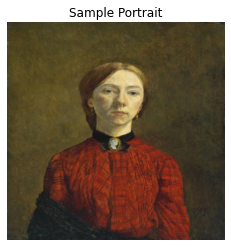

In [138]:
display_random_image(project_folder)

In [182]:
def display_random_images(folder):
  images = []
  for _ in range(4):
    images.append(select_random_image(folder))
  
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=len(images), sharey=True, figsize = (14, 7))
  fig.tight_layout()
  ax1.imshow(images[0])
  ax1.axis("off")
  ax2.imshow(images[1])
  ax2.axis("off")
  ax3.imshow(images[2])
  ax3.axis("off")
  ax4.imshow(images[3])
  ax4.axis("off");

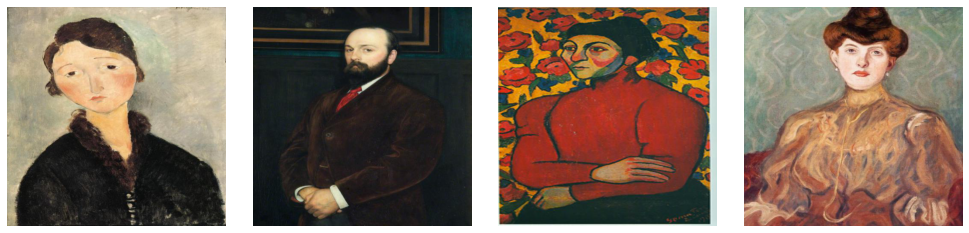

In [184]:
display_random_images(project_folder)

In [202]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import imageio

In [206]:
dataset = keras.preprocessing.image_dataset_from_directory(
    project_folder, label_mode= None, image_size=(96, 96), batch_size=32)

Found 1935 files belonging to 1 classes.


In [207]:
dataset = dataset.map(lambda x: x / 255.0)